In [1]:
!git clone https://github.com/kmasta/Aiffel_DLThon.git

Cloning into 'Aiffel_DLThon'...
remote: Enumerating objects: 348, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 348 (delta 123), reused 195 (delta 78), pack-reused 97 (from 1)
Receiving objects: 100% (348/348), 60.41 MiB | 12.10 MiB/s, done.
Resolving deltas: 100% (147/147), done.
Updating files: 100% (128/128), done.


# Baseline Code

## 필요한 라이브러리 임포트

In [2]:
import yaml
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, ElectraForSequenceClassification
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
import torch
import os

from Aiffel_DLThon.pytorch_code.callback.logger import log_message, log_target_distribution, LoggingCallback
from Aiffel_DLThon.pytorch_code.callback.early_stopping import EarlyStopping
from Aiffel_DLThon.pytorch_code.callback.checkpoint import save_model
from Aiffel_DLThon.pytorch_code.callback.save_results import save_submission

## 모델 정보 불러오기

In [16]:
# Load model name
with open("./Aiffel_DLThon/pytorch_code/config/model_name.yaml", "r") as f:
    model_name_config = yaml.safe_load(f)
model_key = model_name_config["model_name"]

# Load full config for that model
with open(f"./Aiffel_DLThon/pytorch_code/config/{model_key}.yaml", "r") as f:
    config = yaml.safe_load(f)

log_message(f"Running experiment: {config['experiment_name']}", config["log_dir"])

[2025-05-05 11:10:12] Running experiment: klue_roberta_exp1


## 토크나이저, 모델 구현

In [4]:
from transformers import ElectraPreTrainedModel, ElectraModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn.functional as F
import torch.nn as nn

class ElectraTwoStageModel(ElectraPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.electra = ElectraModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.stage1_classifier = nn.Linear(config.hidden_size, 2)  # Binary
        self.stage2_classifier = nn.Linear(config.hidden_size, 4)  # Multiclass

        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None,
            binary_labels=None, multiclass_labels=None):
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        cls_output = self.dropout(outputs.last_hidden_state[:, 0, :])

        # Stage 1: 일반 vs 특수
        stage1_logits = self.stage1_classifier(cls_output)

        # Stage 2: 일반 중 세부 분류
        stage2_logits = self.stage2_classifier(cls_output)

        loss = None
        if binary_labels is not None and multiclass_labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss1 = loss_fct(stage1_logits, binary_labels)

            mask = (binary_labels == 0)
            if mask.sum() > 0:
                loss2 = loss_fct(stage2_logits[mask], multiclass_labels[mask])
                loss = loss1 + loss2
            else:
                loss = loss1

        return SequenceClassifierOutput(
            loss=loss,
            logits=stage1_logits
        )

In [9]:
tokenizer = AutoTokenizer.from_pretrained(config["tokenizer_name"])

'model = ElectraForSequenceClassification.from_pretrained(\n    config["pretrained_model_name"],\n    num_labels=config["num_labels"]\n)'

## 커스텀 데이터셋 클래스(토크나이징)

In [6]:
class TwoStageDataset(Dataset):
    def __init__(self, encodings, binary_labels, multiclass_labels):
        self.encodings = encodings
        self.binary_labels = binary_labels
        self.multiclass_labels = multiclass_labels

    def __len__(self):
        return len(self.binary_labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.binary_labels[idx])
        item["binary_labels"] = torch.tensor(self.binary_labels[idx])
        item["multiclass_labels"] = torch.tensor(self.multiclass_labels[idx])
        return item

## 데이터 불러오기

In [7]:
from sklearn.model_selection import train_test_split

def prepare_two_stage_dataset(texts, labels, tokenizer, max_length=128, test_size=0.2):
    # Stage 1 labels: 0~3 → 0, 4 → 1
    binary_labels = [0 if l in [0, 1, 2, 3] else 1 for l in labels]

    # Stage 2 labels: 0~3은 그대로, 4는 -1
    multiclass_labels = [l if l in [0, 1, 2, 3] else -1 for l in labels]

    # Split 먼저
    train_texts, val_texts, train_binary, val_binary, train_multi, val_multi = train_test_split(
        texts, binary_labels, multiclass_labels, test_size=test_size, stratify=labels, random_state=42
    )

    # Tokenize 각 split
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length,return_tensors="pt" )
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length,return_tensors="pt" )

    # Dataset 생성
    train_dataset = TwoStageDataset(train_encodings, train_binary, train_multi)
    val_dataset = TwoStageDataset(val_encodings, val_binary, val_multi)

    return train_dataset, val_dataset

In [17]:
train_df = pd.read_csv(config["train_file"])
texts = train_df["clean_text"].tolist()
labels = train_df["label"].tolist()

daily_df = pd.read_csv(config["daily_file"])
texts.extend(daily_df["clean_text"].tolist())
labels.extend([4 for _ in daily_df["label"].tolist()])

"""gen1_df = pd.read_csv(config["gen1_file"])
texts.extend(gen1_df["clean_text"].tolist())
labels.extend([4 for _ in gen1_df["label"].tolist()])

gen2_df = pd.read_csv(config["gen2_file"])
texts.extend(gen2_df["clean_text"].tolist())
labels.extend([4 for _ in gen2_df["label"].tolist()])"""

#ai_daily_df = pd.read_csv(config["aihub_daily_file"])
#texts.extend(ai_daily_df["conversation"].tolist())
#labels.extend([4 for _ in ai_daily_df["class"].tolist()])

#dataset = ChatDataset(texts, labels, tokenizer, config["max_length"])

'gen1_df = pd.read_csv(config["gen1_file"])\ntexts.extend(gen1_df["clean_text"].tolist())\nlabels.extend([4 for _ in gen1_df["label"].tolist()])\n\ngen2_df = pd.read_csv(config["gen2_file"])\ntexts.extend(gen2_df["clean_text"].tolist())\nlabels.extend([4 for _ in gen2_df["label"].tolist()])'

In [19]:
train_dataset, val_dataset = prepare_two_stage_dataset(texts, labels, tokenizer)

In [21]:
label_counts = pd.Series(labels).value_counts().sort_index()

print("📊 train label 클래스 분포:")
print(label_counts)

📊 train label 클래스 분포:
0     896
1     981
2     979
3    1094
4    3472
Name: count, dtype: int64


In [ ]:
"""label_counts = pd.Series(val_labels).value_counts().sort_index()

print("📊 validation label 클래스 분포:")
print(label_counts)"""

📊 validation label 클래스 분포:
0     179
1     196
2     196
3     219
4    1454
Name: count, dtype: int64


## 매트릭 함수

In [22]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from collections import Counter

def evaluate_stage1(trainer, val_dataset):
    pred_output = trainer.predict(val_dataset)
    y_true = pred_output.label_ids
    y_pred = np.argmax(pred_output.predictions, axis=1)

    # 메트릭 계산
    f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)

    # 분포 확인
    print("📊 Stage 1 정답 분포:", Counter(y_true))
    print("📊 Stage 1 예측 분포:", Counter(y_pred))
    print("✅ Stage 1 Accuracy:", acc)
    print("✅ Stage 1 F1 (macro):", f1)

    return {
        "f1_macro": f1,
        "accuracy": acc
    }

In [23]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from collections import Counter

def evaluate_stage2(trainer, val_dataset):
    # 예측
    pred_output = trainer.predict(val_dataset)
    y_true = pred_output.label_ids
    y_pred = np.argmax(pred_output.predictions, axis=1)

    # 메트릭 계산
    f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)

    # 분포 확인
    print("📊 정답 분포:", Counter(y_true))
    print("📊 예측 분포:", Counter(y_pred))
    print("✅ Stage 2 Accuracy:", acc)
    print("✅ Stage 2 F1 (macro):", f1)

    return {
        "f1_macro": f1,
        "accuracy": acc
    }


In [ ]:
"""def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }"""

In [24]:
def compute_metrics(pred):

    # 예외 처리: label_ids가 tuple이면 첫 번째 요소만 사용 (binary classification용)
    label_ids = pred.label_ids[0] if isinstance(pred.label_ids, tuple) else pred.label_ids

    preds = np.argmax(pred.predictions, axis=1)

    return {
        "accuracy": accuracy_score(label_ids, preds),
        "f1_macro": f1_score(label_ids, preds, average="macro")
    }

## 모델 준비

In [25]:
training_args = TrainingArguments(
    output_dir='./Aiffel_DLThon/ckpoints/tunib',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=float(2e-5),
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_dir='./Aiffel_DLThon//logs/klue_roberta',
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_strategy="steps",
    logging_steps=50,
    report_to="tensorboard",
)

from transformers import AutoConfig

config = AutoConfig.from_pretrained("tunib/electra-ko-en-base")
two_stage_model = ElectraTwoStageModel(config)

trainer = Trainer(
    model=two_stage_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=2),
        LoggingCallback(),
    ]
)

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

## 모델 학습

In [26]:
trainer.train()
#save_model(two_stage_model, config["output_dir"], epoch=config["epochs"])

<ipython-input-6-cb0432d4889e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.544200,1.401903,0.991919,0.991889
2,1.120600,1.204749,0.929966,0.928712
3,0.746900,0.746248,0.999327,0.999324
4,0.617000,0.626087,0.997306,0.997296
5,0.472600,0.601778,0.997306,0.997296


✅ compute_metrics called
🔍 type(pred.label_ids): <class 'tuple'>
🔍 label_ids shape: (1485,)
🔍 predictions shape: (1485, 2)
[2025-05-05 11:12:52] Epoch 01 | Train Loss: 0.0000 | Val Loss: 1.4019 | Val Acc: 0.9919 | Val F1(Macro): 0.9919


<ipython-input-6-cb0432d4889e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


✅ compute_metrics called
🔍 type(pred.label_ids): <class 'tuple'>
🔍 label_ids shape: (1485,)
🔍 predictions shape: (1485, 2)
[2025-05-05 11:15:12] Epoch 02 | Train Loss: 0.0000 | Val Loss: 1.2047 | Val Acc: 0.9300 | Val F1(Macro): 0.9287


<ipython-input-6-cb0432d4889e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


✅ compute_metrics called
🔍 type(pred.label_ids): <class 'tuple'>
🔍 label_ids shape: (1485,)
🔍 predictions shape: (1485, 2)
[2025-05-05 11:17:28] Epoch 03 | Train Loss: 0.0000 | Val Loss: 0.7462 | Val Acc: 0.9993 | Val F1(Macro): 0.9993


<ipython-input-6-cb0432d4889e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


✅ compute_metrics called
🔍 type(pred.label_ids): <class 'tuple'>
🔍 label_ids shape: (1485,)
🔍 predictions shape: (1485, 2)
[2025-05-05 11:19:46] Epoch 04 | Train Loss: 0.0000 | Val Loss: 0.6261 | Val Acc: 0.9973 | Val F1(Macro): 0.9973


<ipython-input-6-cb0432d4889e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


✅ compute_metrics called
🔍 type(pred.label_ids): <class 'tuple'>
🔍 label_ids shape: (1485,)
🔍 predictions shape: (1485, 2)
[2025-05-05 11:22:17] Epoch 05 | Train Loss: 0.0000 | Val Loss: 0.6018 | Val Acc: 0.9973 | Val F1(Macro): 0.9973


TrainOutput(global_step=930, training_loss=1.0021146999892367, metrics={'train_runtime': 753.8868, 'train_samples_per_second': 39.376, 'train_steps_per_second': 1.234, 'total_flos': 1939218682821120.0, 'train_loss': 1.0021146999892367, 'epoch': 5.0})

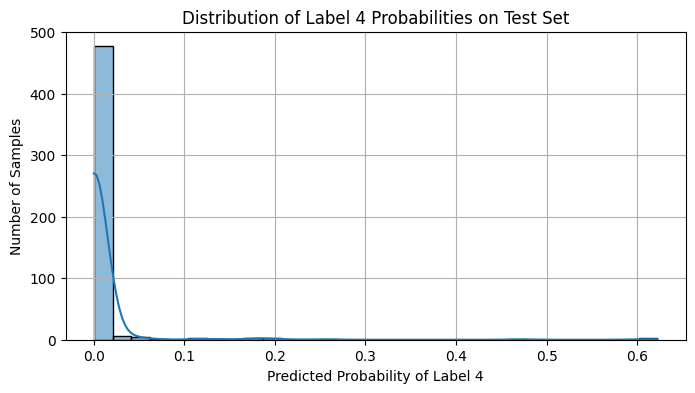

In [31]:
from torch.utils.data import Dataset, DataLoader

model = two_stage_model
class PlainTextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


test_df = pd.read_csv("./Aiffel_DLThon/data/original_data/test.csv")
test_texts = test_df["text"].tolist()

# Dataset & Dataloader
test_dataset = PlainTextDataset(test_texts, tokenizer, 200)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

import torch
from torch.nn.functional import softmax

model.eval()
label4_probs = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(**batch)
        probs = softmax(outputs.logits, dim=-1)
        label4_batch_probs = probs[:, 1].cpu().numpy()
        label4_probs.extend(label4_batch_probs)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(label4_probs, bins=30, kde=True)
plt.title("Distribution of Label 4 Probabilities on Test Set")
plt.xlabel("Predicted Probability of Label 4")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

def evaluate_stage1(model, dataset, batch_size=32):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size)
    preds = []
    labels = []

    for batch in tqdm(dataloader, desc="Stage 1 Evaluation"):
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        token_type_ids = batch["token_type_ids"].to(model.device)
        binary_labels = batch["binary_labels"].to(model.device)

        with torch.no_grad():
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            ).logits  # ✅ Stage 1 logits only

        pred = torch.argmax(logits, dim=1)
        preds.extend(pred.cpu().tolist())
        labels.extend(binary_labels.cpu().tolist())

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')

    print("📊 Stage 1 Evaluation Results")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1 Score (macro): {f1:.4f}")
    print("📋 Classification Report:\n", classification_report(labels, preds, digits=4))
    return {"accuracy": acc, "f1_macro": f1}
stage1_metrics = evaluate_stage1(two_stage_model, val_dataset)


Stage 1 Evaluation: 100%|██████████| 71/71 [00:16<00:00,  4.29it/s]

📊 Stage 1 Evaluation Results
✅ Accuracy: 0.9982
✅ F1 Score (macro): 0.9980
📋 Classification Report:
               precision    recall  f1-score   support

           0     0.9987    0.9962    0.9975       790
           1     0.9979    0.9993    0.9986      1454

    accuracy                         0.9982      2244
   macro avg     0.9983    0.9978    0.9980      2244
weighted avg     0.9982    0.9982    0.9982      2244



In [ ]:
from collections import Counter

binary_preds = np.argmax(trainer.predict(val_dataset).predictions, axis=1)
counter = Counter(binary_preds)
print("✅ Stage 1 예측 분포:", counter)

✅ compute_metrics called
🔍 type(pred.label_ids): <class 'tuple'>
🔍 label_ids shape: (2244,)
🔍 predictions shape: (2244, 2)
✅ Stage 1 예측 분포: Counter({np.int64(1): 1456, np.int64(0): 788})


In [ ]:
stage2_df = train_df[train_df["label"] != 4].copy()
stage2_df = stage2_df.reset_index(drop=True)

texts = stage2_df["clean_text"].tolist()
labels = stage2_df["label"].tolist()  # label: 0~3

encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
class Stage2Dataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
train_dataset = Stage2Dataset(train_encodings, train_labels)
val_dataset = Stage2Dataset(val_encodings, val_labels)

from transformers import ElectraModel, ElectraPreTrainedModel
import torch.nn as nn

class ElectraStage2Classifier(ElectraPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.electra = ElectraModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 4)  # 4-class

        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        cls_output = self.dropout(outputs.last_hidden_state[:, 0, :])
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./stage2_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="tensorboard",
)
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics_stage2(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }
from transformers import AutoConfig

config = AutoConfig.from_pretrained("tunib/electra-ko-en-base", num_labels=4)
model = ElectraStage2Classifier.from_pretrained("tunib/electra-ko-en-base", config=config)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_stage2
)

trainer.train()


Some weights of ElectraStage2Classifier were not initialized from the model checkpoint at tunib/electra-ko-en-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.611600,0.424237,0.849367,0.851038
2,0.307900,0.409940,0.868354,0.869129
3,0.210300,0.496361,0.860759,0.861767
4,0.136600,0.577979,0.879747,0.879266
5,0.059300,0.562851,0.877215,0.877528


TrainOutput(global_step=990, training_loss=0.2893064183418197, metrics={'train_runtime': 472.8509, 'train_samples_per_second': 33.414, 'train_steps_per_second': 2.094, 'total_flos': 1032140851814400.0, 'train_loss': 0.2893064183418197, 'epoch': 5.0})

📊 Stage 2 학습용 라벨 분포:
Label 0: 896
Label 1: 981
Label 2: 979
Label 3: 1094


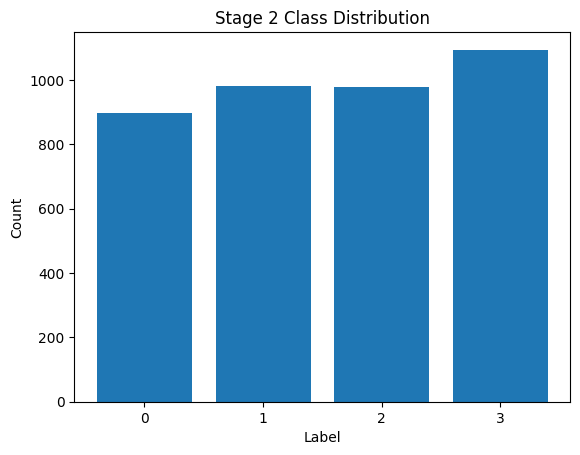

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# 실제 사용한 label 리스트를 넣으세요
# 예: labels = stage2_df["label"].tolist()
stage2_labels = labels  # ✅ ← 여기만 수정

# 분포 확인
label_counts = Counter(stage2_labels)

print("📊 Stage 2 학습용 라벨 분포:")
for label, count in sorted(label_counts.items()):
    print(f"Label {label}: {count}")

# 시각화
plt.bar(label_counts.keys(), label_counts.values())
plt.title("Stage 2 Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks([0, 1, 2, 3])
plt.show()

## 테스트

In [ ]:
from tqdm import tqdm

batch_size = 32  # 또는 16으로 줄일 수 있음
two_stage_model.eval()
model.eval()
final_preds = []
test_df = pd.read_csv("./Aiffel_DLThon/data/original_data/test.csv")
test_texts = test_df["text"].tolist()

for i in tqdm(range(0, len(test_texts), batch_size), desc="Stage 1 + Stage 2 추론"):
    batch_texts = test_texts[i:i + batch_size]

    # 인코딩 + device 이동
    batch_encodings = tokenizer(
        batch_texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )
    batch_encodings = {k: v.to(two_stage_model.device) for k, v in batch_encodings.items()}

    with torch.no_grad():
        # Stage 1 예측
        s1_logits = two_stage_model(**batch_encodings).logits
        s1_preds = torch.argmax(s1_logits, dim=1)

        for j, s1 in enumerate(s1_preds):
            if s1 == 1:
                final_preds.append(4)
            else:
                # Stage 2 예측
                single_input = {
                    key: val[j].unsqueeze(0).to(model.device)
                    for key, val in batch_encodings.items()
                }
                with torch.no_grad():
                    s2_logits = model(**single_input).logits
                    s2_pred = torch.argmax(s2_logits, dim=1).item()
                    final_preds.append(s2_pred)

Stage 1 + Stage 2 추론: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


In [ ]:
from collections import Counter

print("📊 예측 결과 분포:")
print(Counter(final_preds))

📊 예측 결과 분포:
Counter({3: 156, 1: 121, 2: 119, 0: 94, 4: 10})


In [ ]:
for i in range(5):
    print(f"문장: {test_texts[i]}")
    print(f"예측 라벨: {final_preds[i]}")
    print("-" * 30)

문장: 아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네
예측 라벨: 1
------------------------------
문장: 우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? 그렇지? 2달만 파견 잘 갔다오면 승진이야. 네? 저는 별로 가고 싶지 않습니다. 여기 있는 모든사람도 가기 싫어해. 그러니까 막내인 영지씨가 가는게 맞지 정말 죄송합니다. 저는 못갑니다. 장난해? 모두를 위해 영지씨가 희생하는게 싫어? 네. 부당한 방법으로 가는 것 같습니다. 영지씨 안가면 회사생활 오래 못할 것 같은데 그래도 안갈거야? 안가면 지옥일텐데. 그래도 이 방법은 아닌 것 같습니다. 죄송합니다.
예측 라벨: 2
------------------------------
문장: 너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 행실이 맘에 안들어 네 실천할께요 옆에 동기들 좀 본받으란 말야 어? 네 알겠습니다 그래 똑바로해 노럭할께요
예측 라벨: 2
------------------------------
문장: 이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 요즘 듣는 것도 들어봐 음 난 좀 별론데 좋을 줄 알았는데 아쉽네 내 취향은 아닌 듯 배고프다 밥이나 먹으러 가자 그래
예측 라벨: 3
------------------------------
문장: 아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도 말해야지? .켰습니다. 주인님. 오냐. 앞으로도 잘부탁한다 와이파이. 넵. 이렇게만 해? 알겠지?

In [ ]:
save_submission(preds, "./Aiffel_DLThon/data/original_data/submission.csv", './submission.csv')
log_message("Experiment complete.", '.')

[2025-05-05 02:14:55] Experiment complete.


In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, ElectraPreTrainedModel, ElectraModel
from transformers.modeling_outputs import SequenceClassifierOutput
from tqdm import tqdm

# ============================
# ✅ 모델 정의 (통합 모델)
# ============================
class ElectraTwoStageModel(ElectraPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.electra = ElectraModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.stage1_classifier = torch.nn.Linear(config.hidden_size, 2)
        self.stage2_classifier = torch.nn.Linear(config.hidden_size, 4)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None,
                binary_labels=None, multiclass_labels=None):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = self.dropout(outputs.last_hidden_state[:, 0, :])

        stage1_logits = self.stage1_classifier(cls_output)
        stage2_logits = self.stage2_classifier(cls_output)

        loss = None
        if binary_labels is not None and multiclass_labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss1 = loss_fct(stage1_logits, binary_labels)
            mask = (binary_labels == 0)
            if mask.sum() > 0:
                loss2 = loss_fct(stage2_logits[mask], multiclass_labels[mask])
                loss = loss1 + loss2
            else:
                loss = loss1

        return SequenceClassifierOutput(loss=loss, logits=stage1_logits)


# ============================
# ✅ 모델 및 토크나이저 로드
# ============================
from transformers import AutoConfig
MODEL_NAME = "tunib/electra-ko-en-base"
MODEL_PATH = "tunib/electra-ko-en-base"  # 학습된 모델이 저장된 디렉토리

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)
model = ElectraTwoStageModel.from_pretrained(MODEL_PATH, config=config).to("cuda")
model.eval()

# ============================
# ✅ 테스트 데이터 로드
# ============================
test_df = pd.read_csv("./Aiffel_DLThon/data/original_data/test.csv")
test_texts = test_df["text"].tolist()

# ============================
# ✅ 예측 수행
# ============================
final_preds = []

for text in tqdm(test_texts):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(model.device)

    with torch.no_grad():
        # Stage 1 예측
        stage1_logits = model(**inputs).logits
        stage1_pred = torch.argmax(stage1_logits, dim=1).item()

        if stage1_pred == 1:
            final_preds.append(4)
        else:
            # Stage 2 예측
            cls_output = model.dropout(model.electra(**inputs).last_hidden_state[:, 0, :])
            stage2_logits = model.stage2_classifier(cls_output)
            stage2_pred = torch.argmax(stage2_logits, dim=1).item()
            final_preds.append(stage2_pred)

# ============================
# ✅ 제출 파일 저장
# ============================
submission = pd.DataFrame({
    "idx": test_df["idx"],
    "label": final_preds
})
submission.to_csv("submission.csv", index=False)
print("\n✅ submission.csv 저장 완료!")


Some weights of ElectraTwoStageModel were not initialized from the model checkpoint at tunib/electra-ko-en-base and are newly initialized: ['stage1_classifier.bias', 'stage1_classifier.weight', 'stage2_classifier.bias', 'stage2_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 500/500 [00:12<00:00, 38.48it/s]


✅ submission.csv 저장 완료!


In [ ]:
def log_target_distribution(df: pd.DataFrame, log_dir: str):
    """
    주어진 DataFrame에서 'target' 컬럼의 클래스 분포를 로그 파일과 콘솔에 출력합니다.
    """
    if "label" not in df.columns:
        log_message("❌ 'target' 컬럼이 데이터프레임에 없습니다.", log_dir)
        return

    counts = df["label"].value_counts().sort_index()
    log_message("📊 Target 클래스 분포:", log_dir)
    for label, count in counts.items():
        log_message(f"Label {label}: {count}", log_dir)

In [ ]:
# 파일 로딩
df = pd.read_csv('/content/submission.csv')
log_target_distribution(df, '.')

[2025-05-05 02:23:39] 📊 Target 클래스 분포:
[2025-05-05 02:23:39] Label 2: 423
[2025-05-05 02:23:39] Label 4: 77
